Name: Arun Ranjan Sahu<br>
Regd No.: 22552<br>
Paper Title: Computer Vision<br>
Paper Code: MTCS-205-HCI-3(P)<br>

### Implementation of LNIFT: Locally Normalized Image for Rotation Invariant Multimodal Feature Matching.<br>

This paper explains how to do feature matching between images taken from two different modes of camera. There has been other state of Art method like RIFT. RIFT uses Fourier transform to do feature matching because of which it is computationally expensive to do feature matching using RIFT.<br>
LNIFT provides feature matching in spatial domain and reduces time complexity.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_PATH = "/content/drive/My Drive/HCI3_2023/Images/22552_ ArunRanjanSahu/SE_2"

Reading an RGB image and converting it to negative image. I have chosen this two images as two different images for LNIFT.

Text(0.5, 1.0, 'Negative Image')

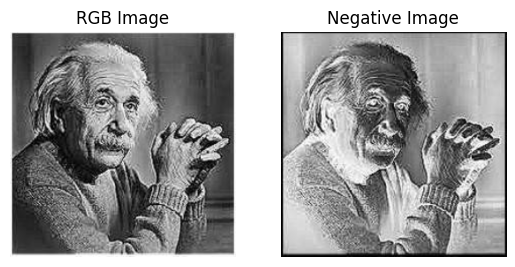

In [5]:
img1 = cv2.imread(IMAGE_PATH+'/sharp.jpg')
img1 = cv2.resize(img1,(256,256))
img_1rgb = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img_1g = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)


img_2 = abs(255-img_1rgb)
img_2g = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
fig,ax = plt.subplots(1,2)
ax[0].set_axis_off(),ax[1].set_axis_off()
ax[0].imshow(img_1rgb)
ax[0].set_title("RGB Image")
ax[1].imshow(img_2)
ax[1].set_title("Negative Image")
# print(img1.shape)

# Methodology<br>
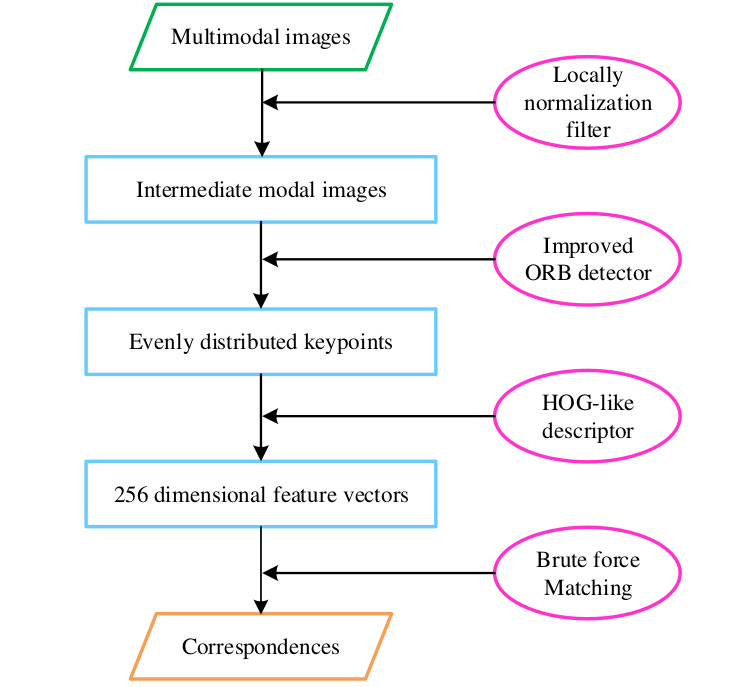

### Step 1: Normalize the multimodal image<br>
Local normalization filter. The local normalization filter is basically unsharp masking. If $K>1$ then it is called high boost filtering.<br>
In this paper average filtering is used for smooting image because of its efficiency.<br>
I have not used the efficient way of using average filter. I have used opencv methods for smoothing.

In [6]:
def localNormalization(img,s,k):
    kernel = np.ones((2*s+1,2*s+1),np.float32)/((2*s+1)*(2*s+1))
    blur_image = cv2.filter2D(img,-1,kernel)
    # mask for unsharp masking
    mask = img - blur_image
    return img + k*mask

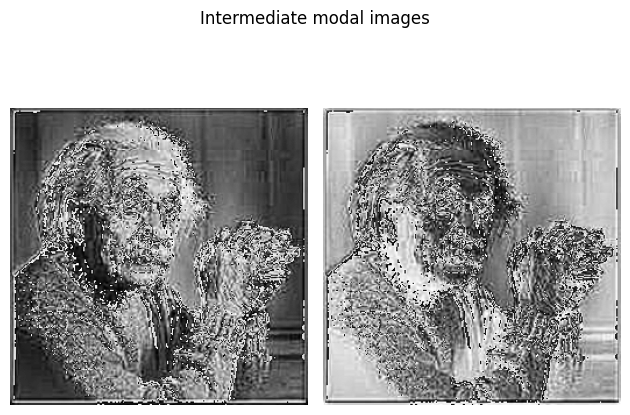

In [7]:
norm_img_1 = localNormalization(img=img_1g,s=3,k=1)
norm_img_2 = localNormalization(img=img_2g,s=3,k=1)

fig,ax = plt.subplots(1,2)
ax[0].imshow(norm_img_1,cmap='gray')
ax[0].set_axis_off(),ax[1].set_axis_off()
ax[1].imshow(norm_img_2,cmap='gray')
fig.suptitle("Intermediate modal images")
fig.tight_layout()
# print(norm_img_1.shape,norm_img_2.shape)

### Step 2: Improved ORB detector<br>
Here improved ORB detector is used for extracting features from the image. Although ORB detector uses different pyramid levels to achieve scale invariance, it is computationally expensive. In the improve ORB detector the features are detected from the fist level.

In [8]:
import random
def improved_ORB_detector(img,features,threshold):
    np.random.seed(42)
    orb = cv2.ORB_create(nfeatures=features,edgeThreshold=threshold,nlevels=1)
    keypoints,desc = orb.detectAndCompute(img,None)
    # The keypoints are sorted according to "Harris scores"
    keypoints_sorted = sorted(keypoints, key=lambda x: x.response, reverse=True)
    desc_sorted = []
    for k in keypoints_sorted:
        idx = keypoints.index(k)
        desc_sorted.append(desc[idx])
    desc_sorted = np.array(desc_sorted)
    # Normalize the angles to be between 0 and 180 degrees
    for kp in keypoints:
        angle = kp.angle
        if angle < 0:
            angle += 180
        kp.angle = angle
    # This n becomes an hyperparameter as it depends on the number of keypoints detected by ORB
    n = 400
    num_kpts = len(keypoints)
    # NOTE: Random function gives uniform distribution
    # Thats how ANMS is implemented here. To extracted features which are uniformly distributed over the image
    idx = np.random.choice(num_kpts, size=n, replace=False)
    uniform_kpts,desc = [keypoints_sorted[i] for i in idx], [desc_sorted[i] for i in idx]
    return np.array(uniform_kpts),np.array(desc)

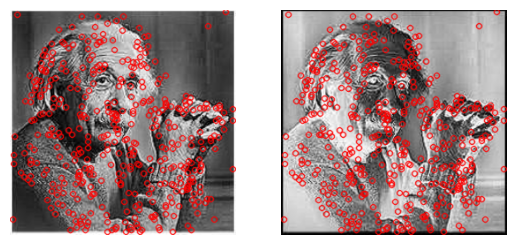

In [9]:
keypts1,desc1 = improved_ORB_detector(norm_img_1,5000,1)
keypts2,desc2 = improved_ORB_detector(norm_img_2,5000,1)
kp_img1 = cv2.drawKeypoints(img_1rgb, keypts1[:], None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
kp_img2 = cv2.drawKeypoints(img_2, keypts2[:], None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
fig,ax = plt.subplots(1,2)
ax[0].set_axis_off(),ax[1].set_axis_off()
ax[0].imshow(kp_img1)
ax[1].imshow(kp_img2)

### Step 3: HOG-like Descriptor


Rotate local image patch according to dominant angle of the keypoint to achieve rotation invariance.


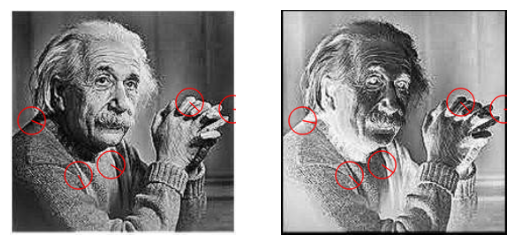

In [10]:
# Compute the dominant orientation for each keypoint
for kp in keypts1:
    # Get the keypoint coordinates and size
    x, y = kp.pt
    size = int(kp.size)

    # Extract the keypoint patch from the intermediate modal image
    patch = norm_img_1[int(y-size/2):int(y+size/2), int(x-size/2):int(x+size/2)]

    # Compute the local image gradient histogram for the patch
    hist = cv2.calcHist([patch], [0], None, [9], [0, 180])
    # Compute the dominant orientation using the histogram
    max_idx = cv2.minMaxLoc(hist)
    kp.angle = max_idx[0]


# Compute the dominant orientation for each keypoint
for kp in keypts2:
    # Get the keypoint coordinates and size
    x, y = kp.pt
    size = int(kp.size)

    # Extract the keypoint patch from the intermediate modal image
    patch = norm_img_2[int(y-size/2):int(y+size/2), int(x-size/2):int(x+size/2)]

    # Compute the local image gradient histogram for the patch
    hist = cv2.calcHist([patch], [0], None, [9], [0, 180])
    # Compute the dominant orientation using the histogram
    max_idx = cv2.minMaxLoc(hist)
    kp.angle = max_idx[0]



kp_img1 = cv2.drawKeypoints(img_1rgb, keypts1[:5], None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
kp_img2 = cv2.drawKeypoints(img_2, keypts2[:5], None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
fig,ax = plt.subplots(1,2)
ax[0].set_axis_off(),ax[1].set_axis_off()
ax[0].imshow(kp_img1)
ax[1].imshow(kp_img2)

### Match the kepoints

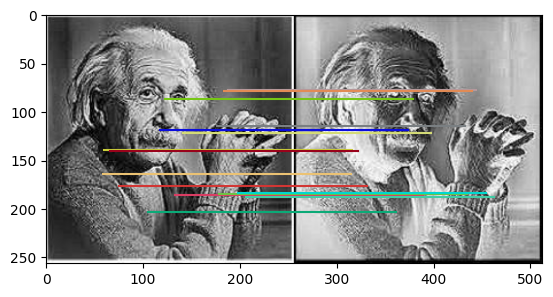

In [15]:
from skimage.feature import match_descriptors, plot_matches,hog

d1=[]
for kp in keypts1:
    x,y = kp.pt
    # Patch size used in the paper
    half_patch_size = 96//2
    # A check condition for the patch not being outside the boundary of the image
    if (
        x - half_patch_size >= 0
        and x + half_patch_size < norm_img_1.shape[1]
        and y - half_patch_size >= 0
        and y + half_patch_size < norm_img_1.shape[0]
    ):
    # Get the patch around the keypoint
        patch = norm_img_1[int(y)-half_patch_size:int(y)+half_patch_size, int(x)-half_patch_size:int(x)+half_patch_size]
        fd1 = hog(patch, orientations=4, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1))
        d1.append((fd1,kp))
d2=[]
for kp in keypts2:
    x,y = kp.pt
    # Patch size used in the paper
    half_patch_size = 96//2
    # A check condition for the patch not being outside the boundary of the image
    if (
        x - half_patch_size >= 0
        and x + half_patch_size < norm_img_1.shape[1]
        and y - half_patch_size >= 0
        and y + half_patch_size < norm_img_1.shape[0]
    ):
    # Get the patch around the keypoint
        patch = norm_img_2[int(y)-half_patch_size:int(y)+half_patch_size, int(x)-half_patch_size:int(x)+half_patch_size]
        fd2 = hog(patch, orientations=4, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1))
        # Here we need to add keypoints to the fd..
        d2.append((fd2,kp))
desc1, keypts1 = zip(*d1)
desc2, keypts2 = zip(*d2)
f1 = np.array([kp.pt for kp in keypts1])
f2 = np.array([kp.pt for kp in keypts2])

matches = match_descriptors(np.array(desc1), np.array(desc2))
fig, ax = plt.subplots()
plt.gray()
plot_matches(ax,img_1rgb, img_2, f1, f2, matches[:15],only_matches=True)